<a href="https://colab.research.google.com/github/tlysenko/ML-notebooks/blob/master/Toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic comment classification with Tensorflow and data preprocessing with NLTK

Dataset: [Kaggle Toxic comment classifidcation challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) 

#### Installing the **libraries**

In [17]:
!pip install tensorflow==2.0.0

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import nltk

import seaborn as sns
import matplotlib.pyplot as plt


## Data Exploration

In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_subm = pd.read_csv('sample_submission.csv')

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111699 entries, 0 to 111698
Data columns (total 8 columns):
id               111699 non-null object
comment_text     111699 non-null object
toxic            111699 non-null int64
severe_toxic     111699 non-null int64
obscene          111699 non-null int64
threat           111699 non-null int64
insult           111699 non-null int64
identity_hate    111699 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.8+ MB


### Missing data

In [20]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [21]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0
2,5570f7207bade92f,I depersonalized it. It's sad how you don't ob...,0,0,0,0,0,0
3,a17d6408ffb98139,Thats because I was blocked before I could dis...,0,0,0,0,0,0
4,11b1d25d77ffd834,"I apologise for this, I was just angry with ha...",0,0,0,0,0,0


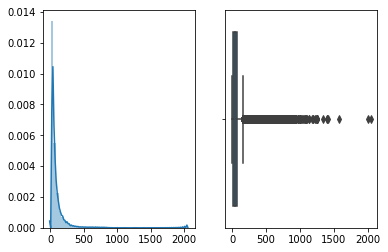

In [22]:
# Sentence length 
snt_len = [len(s.split(' ')) for s in df_train['comment_text']]
plt.subplot(1,2,1)
sns.distplot(snt_len)
plt.subplot(1,2,2)
sns.boxplot(snt_len);

#### Discovering the target variable

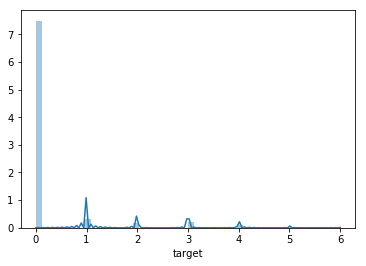

In [23]:
df_train['target'] = [ sum( [row[1]['toxic'], row[1]['severe_toxic'], row[1]['obscene'], row[1]['threat'], 
                             row[1]['insult'], row[1]['identity_hate']]) for row in df_train.iterrows() ]
sns.distplot(df_train['target']);

**There are comments with classified to several categories. That means we're deling with the multilabel classification problem.** 

## Data preparation
 1. Lowercase
 2. Tokenize and remove numericals
 3. Stemming     
 4. Removing stop words
 5. Rejoin the words

In [0]:
class DataPrep:
  def __init__(self, df):
    self.df = df

    nltk.download('punkt')  
    nltk.download('stopwords')

  def get_tokens(self, comment):
      tokens = nltk.word_tokenize(comment)
      clean_tokens = [s for s in tokens if s.isalpha()]
      return clean_tokens

  def stem_list(self, my_list):
      from nltk.stem.snowball import SnowballStemmer
      stemming = SnowballStemmer("english")
      stemmed_list = [stemming.stem(word) for word in my_list]
      return stemmed_list

  def remove_stops(self,my_list):
      from nltk.corpus import stopwords
      stops = set(stopwords.words("english"))
      meaningful_words = [w for w in my_list if not w in stops]
      return (meaningful_words)

  def rejoin_words(self,my_list):
      joined_words = ( " ".join(my_list))
      return joined_words

  def pipeline(self):
    # 1. Lowercase
    self.df['tmp'] = self.df['comment_text'].str.lower()
    # 2. Tokenize and remove numericals
    self.df['tmp'] = [self.get_tokens(line) for line in self.df['tmp']]
    # 3. Stemming     
    self.df['tmp'] = [self.stem_list(l) for l in self.df['tmp']]
    # 4. Removing stop words
    self.df['tmp'] = [self.remove_stops(l) for l in self.df['tmp']]
    # 5. Rejoin the words
    self.df['processed'] = [self.rejoin_words(l) for l in self.df['tmp']]
    self.df.drop('tmp',axis=1, inplace = True)


In [25]:
MakeData = DataPrep(df_train)
MakeData.pipeline()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
df_train.head()[:2]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,processed
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0,0,prove ca
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0,0,major edit summari receiv messag vote candid a...


## Data preparaiton for the model

In [0]:
# Target variable 
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = df_train[list_classes].values

# Train data 
sentences = df_train['processed'].tolist()
n = int(len(sentences)*0.8)

In [0]:
# Split for train and val
trn_snt = sentences[:n]
tst_snt = sentences[n:]

trn_tgt = y[:n]
tst_tgt = y[n:]

In [0]:
# Hyper parameters
max_features = 20000
embedding_dim = 128
maxlen = 200

In [0]:
tf_tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tf_tokenizer.fit_on_texts(trn_snt)

trn_seq = tf_tokenizer.texts_to_sequences(trn_snt)
trn_pad = pad_sequences(trn_seq, padding='post',maxlen=maxlen)

tst_seq = tf_tokenizer.texts_to_sequences(tst_snt)
tst_pad = pad_sequences(tst_seq, padding='post',maxlen=maxlen)

## Model 1: Baseline

In [0]:
def create_model():
    return tf.keras.Sequential([
                                tf.keras.layers.Embedding(max_features, embedding_dim),
                                tf.keras.layers.GlobalAveragePooling1D(),
                                tf.keras.layers.Dense(32, activation='relu'),
                                tf.keras.layers.Dense(6, activation='sigmoid')
    ])

In [0]:
import os
import datetime
def train_model():
  
  model = create_model()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  %tensorboard --logdir logs 
  model.fit(x=trn_pad, 
                    y=trn_tgt, 
                    epochs=2, 
                    validation_data=(tst_pad, tst_tgt),
                    callbacks=[tensorboard_callback])
  
  

train_model()

In [0]:
model_1_GAP = tf.keras.Sequential([
                             tf.keras.layers.Embedding(max_features, embedding_dim),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(6, activation='sigmoid')
                            ])
model_1_GAP.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_1_GAP.summary()

In [0]:
num_epochs = 2

%load_ext tensorboard

tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()), histogram_freq=1)

%tensorboard --logdir logs

model_1_GAP_history = model_1_GAP.fit(trn_pad, 
                            trn_tgt, 
                            epochs=num_epochs, 
                            validation_data=(tst_pad, tst_tgt),
                            callbacks = [tensorboard])


In [0]:
tf.saved_model.save(model_1_GAP, "/tmp/")

In [0]:
MakeData = DataPrep(df_test)
MakeData.pipeline()
df_test.head()

In [0]:
sentences_test = df_test['processed']

trn_test = tf_tokenizer.texts_to_sequences(sentences_test)
trn_test_pad = pad_sequences(trn_tes, padding='post',maxlen=maxlen)

model_1_GAP.predict(trn_test_pad)